In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False
path = 'c:/Windows/Fonts/malgun.ttf'
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Chapter 6. 알고리즘 체인과 파이프라인

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

In [3]:
# 훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


### 6.1 데이터 전처리와 매개변수 선택

In [4]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


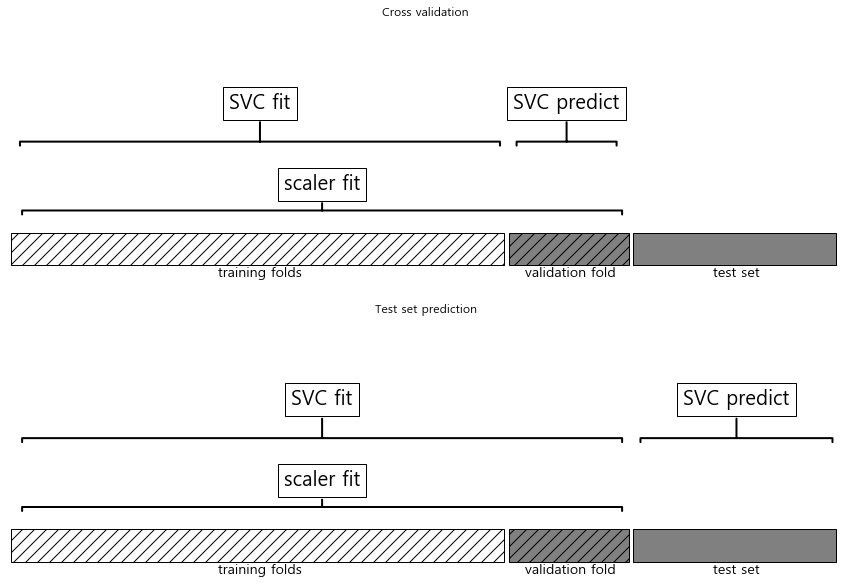

In [5]:
mglearn.plots.plot_improper_processing()

### 6.2 파이프라인 구축하기

In [6]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [8]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


### 6.3 그리드 서치에 파이프라인 적용하기

In [9]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [10]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: {}".format(grid.best_params_))

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


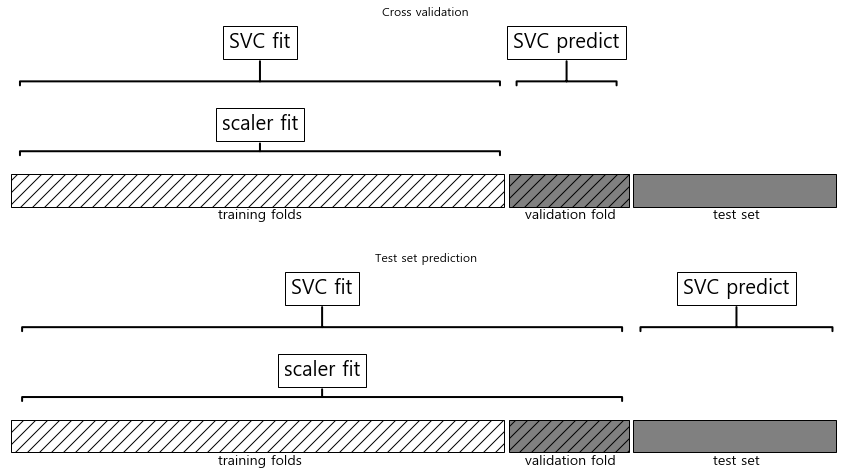

In [11]:
mglearn.plots.plot_proper_processing()

In [12]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [13]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수 (릿지): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

교차 검증 점수 (릿지): 0.91


In [15]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수 (파이프라인): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

교차 검증 점수 (파이프라인): -0.25


### 6.4 파이프라인 인터페이스

In [16]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [17]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

#### 6.4.1 make_pipleline을 사용한 파이프라인 생성

In [18]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [19]:
print("파이프라인 단계:\n{}".format(pipe_short.steps))

파이프라인 단계:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n{}".format(pipe.steps))

파이프라인 단계:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


#### 6.4.2 단계 속성에 접근하기

In [21]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### 6.4.3 그리드 서치 안의 파이프라인의 속성에 접근하기

In [22]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [23]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

In [25]:
print("최상의 모델:\n{}".format(grid.best_estimator_))

최상의 모델:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [26]:
print("로지스틱 회귀 단계:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

로지스틱 회귀 단계:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [27]:
print("로지스틱 회귀 계수:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

로지스틱 회귀 계수:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

In [28]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [29]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [30]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                         

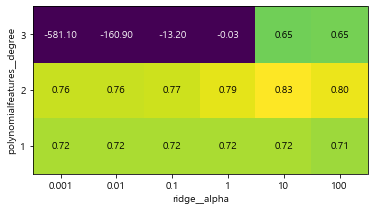

In [31]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [32]:
print("최적의 매개변수: {}".format(grid.best_params_))

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [33]:
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [34]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수: 0.63


### 6.6 모델 선택을 위한 그리드 서치

In [35]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [36]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


## 요약 및 정리
- 실제 머신러닝 어플리케이션에서는 모델을 단독으로 사용하는 경우가 거의 없으며 여러 처리 단계가 연속해서 이뤄짐.
- Pipeline 파이썬 클래슨느 코드를 간결하게 작성하도록 도와주고, Pipeline을 사용하지 않고 처리 단계를 구현할 때 발생할 수 있는 실수를 방지해줌.
- 특성 추출, 전처리, 모델의 완벽한 조합을 찾는 것은 예술에 가까운 일이라 어느 정도 시행착오가 필요함.
- 파이프라인을 사용하면 여러 다른 처리 단계를 손쉽게 시도해볼 수 있음.